# Find the right M for (robUP!) for the spacecraft

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.spatial import ConvexHull
import time

from models.spacecraft import Model, SpacecraftProblem
from models.spacecraft import SpacecraftSimulator

### Define simulator

In [2]:
simulator = SpacecraftSimulator()
simulator

### Load model

In [3]:
model = Model()
model

[spacecraft::__init__] Initializing spacecraft Model 
                       (linear, uncertain mass and inertia).
[spacecraft::reset] resetting mass, J, and deltas.


### Define problem 

In [4]:
# problem definition
s13     = np.sqrt(1./3.)
x_init  = np.array([1,0.2,0.0,  1e-4,1e-4,1e-4,  -0.5,0.5,-0.5,0.5,  0,0,0])
x_goal  = np.array([1.2,4.8,2.0,  1e-4,1e-4,1e-4,  s13,0.,s13,s13,     0,0,0])
N       = 21

simulator.state = x_init
simulator.x0    = x_init

problem = SpacecraftProblem(x0=x_init, xgoal=x_goal, N=N)

Initializing problem with 2 spherical obstacles.
[SpacecraftProblem::__init__] 2 sphere obs, and 0 poly obs.


# Batched experiments

In [5]:
x_dim, u_dim = simulator.n_x, simulator.n_u

In [6]:
T     = 20
B     = 500
M_vec = [int(50), int(100), int(200)]

# -----------------------------
# Simulate true system in batch
Xs_true, Qs_true, Us_true = np.zeros((B, T+1, x_dim)), np.zeros((B, T+1, x_dim, x_dim)), np.zeros((B, T, u_dim))

Xs_true[:,0,:]  = simulator.sample_states(B)
for i in range(B):
    Us_true[i,:,:] = 1e-2 * simulator.sample_controls(T)
    simulator.state = Xs_true[i,0,:].copy()
    for t in range(T):
        simulator.state = simulator.f_dt(simulator.state, Us_true[i,t,:])
        Xs_true[i,t+1,:] = simulator.state.copy()
# -----------------------------

# -----------------------------
# (robUP!)
Xs_robUP_all = []
for M in M_vec:
    elapsed_time = 0
    
    Xs_robUP = np.zeros((B, M, T+1, x_dim))
    for i in range(B):
        start_time = time.time()
        
        # First, predict means
        Unom       = Us_true[i,:,:].T
        Xmean      = np.zeros((T+1,x_dim))
        Xmean[0,:] = Xs_true[i,0,:]
        for k in range(0,T):
            Xmean[k+1,:] = model.predict_mean(Xmean[k,:], Unom[:,k])

        # (robUP!)
        Xs, Us = model.simulate_batch(Xmean[0,:], Xmean.T, Unom,
                                    N_MC      = M,
                                    B_feedback= False, 
                                    B_resample= True)

        model.adv_sample_params(Xs, Us)

        Xs, Us = model.simulate_batch(Xmean[0,:], Xmean.T, Unom,
                                    N_MC      = M,
                                    B_feedback= False, 
                                    B_resample= False)
        
        Xs_robUP[i,:,:,:] = np.swapaxes(Xs, 1,2)        
            
        elapsed_time += time.time()-start_time
            
    print('(robUP) elapsed time for M =',M,':',elapsed_time/B)
    Xs_robUP_all.append(Xs_robUP)
# -----------------------------

(robUP) elapsed time for M = 50 : 0.08048460817337036
(robUP) elapsed time for M = 100 : 0.16372157049179076
(robUP) elapsed time for M = 200 : 0.30626295375823975


### Compute Positions volume

In [7]:
idx = [0,1,2]

print('Computing (robUP!) volumes')
vols_pos_robUP_ratios = []
for m_id in range(len(M_vec)):
    print('M_i = ', m_id)
    vols_pos_robUP = np.zeros((B,T+1))
    for i in range(B):
        for t in range(1,T+1):
            vols_pos_robUP[i,t] = ConvexHull(Xs_robUP_all[m_id][i,:,t,idx].T).volume
    vols_pos_robUP_ratios.append( vols_pos_robUP )

Computing (robUP!) volumes
M_i =  0
M_i =  1
M_i =  2


## Results: Total volume

/home/thomas/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


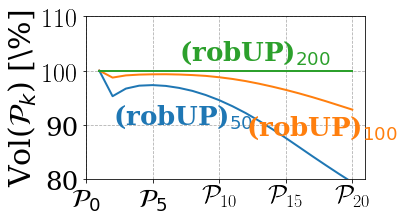

In [8]:
# Normalize in [%]
vols_true  = np.mean(vols_pos_robUP_ratios[-1], 0)
vols_robUP = vols_pos_robUP_ratios
vols_robUP = []
for m_id in range(len(M_vec)):
    vols_robUP.append(100*vols_pos_robUP_ratios[m_id]/vols_true)

from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(5, 3))

# ----------------------------
# (robUP!)
for M_id, M in enumerate(M_vec):
    label_str = r'(robUP)${}_{' + str(int(M))+'}$'
    mean_vols_robUP =        np.mean(vols_robUP[M_id], 0)
    plt.plot(np.arange(T+1), mean_vols_robUP,         'C'+str(M_id), linewidth=2)
    
    if M_id==2:
        plt.text(7, mean_vols_robUP[5]+2, label_str, color='C'+str(M_id), fontsize=26, fontweight='bold')
    elif M_id==1:
        plt.text(12, mean_vols_robUP[5]-11, label_str, color='C'+str(M_id), fontsize=26, fontweight='bold')
    elif M_id==0:
        plt.text(2, mean_vols_robUP[5]-7, label_str, color='C'+str(M_id), fontsize=26, fontweight='bold')
# ----------------------------


rc('text', usetex=True)

ax.tick_params("both", labelsize=26) 

labels_X = []
for i in range(0,T+1,5):
    labels_X.append(r'$\mathcal{P}_{' + str(i) + '}$')
plt.xticks(np.arange(0,T+1,5), (labels_X))

plt.ylim([80,110])

ax.set_ylabel(r'Vol($\mathcal{P}_k$) [\%]', rotation="vertical",fontsize=30)#, labelpad=24)
plt.grid(True, which='both', linestyle='--')

## Compare number of adv. steps

In [9]:
nadv_vec = [1,2,3]
M        = int(100)

# -----------------------------
# (robUP!)
Xs_robUP_all = []
for nadv in nadv_vec:
    elapsed_time = 0
    
    Xs_robUP = np.zeros((B, M, T+1, x_dim))
    for i in range(B):
        start_time = time.time()
        
        # First, predict means
        Unom       = Us_true[i,:,:].T
        Xmean      = np.zeros((T+1,x_dim))
        Xmean[0,:] = Xs_true[i,0,:]
        for k in range(0,T):
            Xmean[k+1,:] = model.predict_mean(Xmean[k,:], Unom[:,k])

        # (robUP!)
        for nadv_i in range(nadv):
            if nadv_i == 0:
                Xs, Us = model.simulate_batch(Xmean[0,:], Xmean.T, Unom,
                                            N_MC      = M,
                                            B_feedback= False, 
                                            B_resample= True)
            else:
                Xs, Us = model.simulate_batch(Xmean[0,:], Xmean.T, Unom,
                                            N_MC      = M,
                                            B_feedback= False, 
                                            B_resample= False)
            model.adv_sample_params(Xs, Us)
            
        Xs, Us = model.simulate_batch(Xmean[0,:], Xmean.T, Unom,
                                    N_MC      = M,
                                    B_feedback= False, 
                                    B_resample= False)
        
        Xs_robUP[i,:,:,:] = np.swapaxes(Xs, 1,2)        
            
        elapsed_time += time.time()-start_time
            
    print('(robUP) elapsed time for M =',M,':',elapsed_time/B)
    Xs_robUP_all.append(Xs_robUP)
# -----------------------------

(robUP) elapsed time for M = 100 : 0.15828202056884766
(robUP) elapsed time for M = 100 : 0.3162124347686768
(robUP) elapsed time for M = 100 : 0.4711662359237671


In [10]:
idx = [0,1,2]

print('Computing (robUP!) volumes')
vols_pos_robUP_ratios = []
for nadv_i in range(len(nadv_vec)):
    print('nadv_i = ', nadv_i)
    vols_pos_robUP = np.zeros((B,T+1))
    for i in range(B):
        for t in range(1,T+1):
            vols_pos_robUP[i,t] = ConvexHull(Xs_robUP_all[nadv_i][i,:,t,idx].T).volume
    vols_pos_robUP_ratios.append( vols_pos_robUP )

Computing (robUP!) volumes
nadv_i =  0
nadv_i =  1
nadv_i =  2


/home/thomas/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


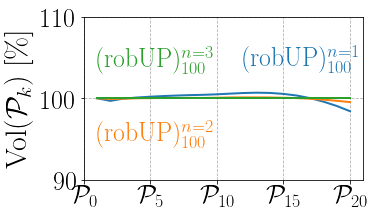

In [11]:
# Normalize in [%]
# vol_true = 100.
vols_true  = np.mean(vols_pos_robUP_ratios[-1], 0)
vols_robUP = vols_pos_robUP_ratios
vols_robUP = []
for nadv_i in range(len(nadv_vec)):
    vols_robUP.append(100*vols_pos_robUP_ratios[nadv_i]/vols_true)

from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(5, 3))

# ----------------------------
# (robUP!)
for nadv_i, nadv in enumerate(nadv_vec):
    label_str = r'(robUP)${}^{n=' + str(int(nadv))+'}_{100}$'
    mean_vols_robUP =        np.mean(vols_robUP[nadv_i], 0)
    plt.plot(np.arange(T+1), mean_vols_robUP,         'C'+str(nadv_i), linewidth=2)#, label=label_str)
    
    if nadv_i==2:
        plt.text(1, mean_vols_robUP[5]+3, label_str, color='C'+str(nadv_i), fontsize=26, fontweight='bold')
    elif nadv_i==1:
        plt.text(1, mean_vols_robUP[5]-6, label_str, color='C'+str(nadv_i), fontsize=26, fontweight='bold')
    elif nadv_i==0:
        plt.text(12, mean_vols_robUP[5]+3, label_str, color='C'+str(nadv_i), fontsize=26, fontweight='bold')
# ----------------------------


rc('text', usetex=True)

ax.tick_params("both", labelsize=26) 

labels_X = []
for i in range(0,T+1,5):
    labels_X.append(r'$\mathcal{P}_{' + str(i) + '}$')
plt.xticks(np.arange(0,T+1,5), (labels_X))

plt.ylim([90,110])

ax.set_ylabel(r'Vol($\mathcal{P}_k$) [\%]', rotation="vertical",fontsize=30)#, labelpad=24)
plt.grid(True, which='both', linestyle='--')